# Predicting brain activity with encoding models

Contained below is a variation of the **very** recently published tutorial on `img2fmri`, a tool from [Bennett & Baldassano (2023)](https://apertureneuro.org/article/87545-img2fmri-a-python-package-for-predicting-group-level-fmri-responses-to-visual-stimuli-using-deep-neural-networks). In this problem set, we will borrow liberally from the tutorial notebook they created to show-off `img2fmri`, while adding in content related to this course, like questions. Below is the helpful introduction they provide:

>Here we present `img2fmri`, a python package and prediction model that allows for prediction of group-averaged cortical responses to visual stimuli. We are publicly releasing this package to aid research investigations into brain responses to visual stimuli, specifically how dynamics in human fMRI responses might be influenced by dynamics in stimuli itself. We encourage viewers to read the science background and summary prior to reading through this notebook, titled `science_overview.pdf`. 
> 
>Our model is built by combining a pretrained ResNet-18 DNN with a linear regression model to predict fMRI responses to individual images. The mapping from DNN to the brain is fit using data from the open source BOLD5000 project ([Chang et al. 2019](https://doi.org/10.1038/s41597-019-0052-3)), which includes fMRI responses for three subjects viewing 4916 unique images drawn from ImageNet ([Deng et al. 2009](https://doi.org/10.1109/CVPR.2009.5206848)), COCO ([Lin et al. 2014](https://doi.org/10.48550/arXiv.1405.0312)), and SUN ([Xiao et al. 2010](https://doi.org/10.1109/CVPR.2010.5539970)). For each image, we predict activity patterns for three visual regions of interest (ROIs) in each subject's brain: the lateral occipital complex (LOC), an object-selective region ([Malach et al. 1995](https://doi.org/10.1073/pnas.92.18.8135)), as well as the retrosplenial cortex (RSC) and the parahippocampal place area (PPA), both scene-selective regions ([Epstein 2008](https://doi.org/10.1016/j.tics.2008.07.004)). OPA and Early Visual cortex is also included.
> 
>For more information on the training of our model using the open source BOLD5000 dataset and pretrained ResNet-18 DNN, we have included a notebook within our `model_training` folder that outlines this process and allows for extensions to other feature-detecting models.

<center>
<img src="https://raw.githubusercontent.com/dpmlab/img2fmri/main/model_overview.png" width="700" class="center"/>
</center>

If you want a reminder of how CNNs (referred to as DNNs above) work, you should review this [website](https://poloclub.github.io/cnn-explainer/) we highlighted in Week 5.

## Critical framing
Before diving in, let's emphasize that this tool is trying to do something **very hard**. This tool was trained on 3 adults' data looking at a few thousand images of scenes and objects and is being used to predict the brain response in **all** fMRI participants to **any** stimulus. This is out-of-sample in an extreme way: in this notebook we will use `img2fmri` to predict brain activity in **new participants** looking at **new stimuli** from **new categories** (e.g., faces) with **new presentation formats** (e.g., movies instead of images). Consider by contrast encoding methods, which are trained on hours of data from individual participants in order to predict their brain responses to stimuli that are as close as possible to those used for training. `img2fmri` is not expected to exceed the performance of these methods, but instead is the only real option available to predict the neural responses of participants when you have *no other data from them*. That is a hard challenge, so success should be calibrated appropriately.

## Goals:
    1. Learn how to interact with published code and replicate it on your system
    2. Use img2fmri to predict the brain's response to visual content
    3. Compare the predictions to the ground truth response
    4. Test the generalization of img2fmri to movie stimuli

## Table of Contents
[1. Setup](#setup)  
[2. Twinset prediction](#twinpred)  
[3. Twinset testing](#twintest)  
[4. PartlyCloudy prediction](#pcpred)  
[5. PartlyCloudy testing](#pctest)  

#### Exercises
>[1](#ex1)   [2](#ex2)  [3](#ex3)  [4](#ex4)  [5](#ex5)  [6](#ex6)  [7](#ex7)  [8](#ex8)   [9](#ex9)  [10](#ex10)  [11](#ex11)  [12](#ex12)  [13](#ex13)  [14](#ex14)  
>[Novel contribution](#novel)  

# 1. Setup<a id=setup ></a>

<div class="alert alert-block alert-info"> If you are reading this and haven't followed the steps on the README, stop reading now and go do that. The notebook won't run if you don't follow the README</div>

The dataset used for training img2fmri is from BOLD5000, as described [here](https://doi.org/10.1038/s41597-019-0052-3).   
Two datasets were used to validate img2fmri. This tests a strong version of generalization, since img2fmri was not trained on either this data (or even dynamic data).  
The *twinset* dataset ([Mohsenzadeh et al. 2019](https://doi.org/10.3390/vision3010008)) is a event related design of 15 adults viewing 156 images. These images can also be segmented into five categories: Scenes, Objects, Animals, Bodies, Faces:
<center>
    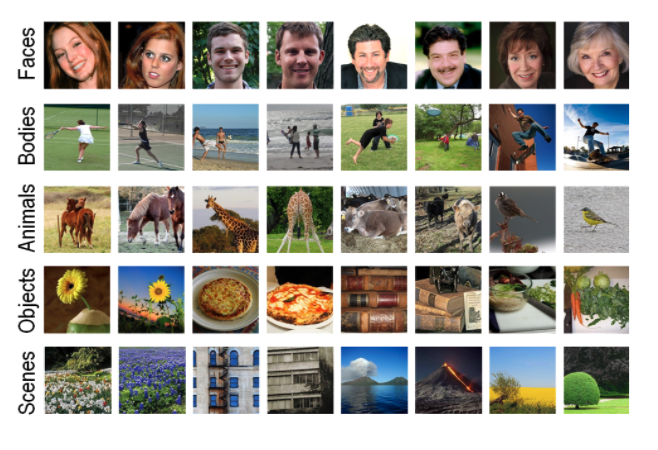
</center>  

*Partly Cloudy* is a movie watching dataset, primarily focusing on child participants, but here it is being considered for the adult participants that were also collected ([Richardson et al. 2018](https://doi.org/10.1038/s41467-018-03399-2)).


**Exercise 1:**<a id=ex1 ></a> Answer the following questions about the datasets:

**Q:** Why is the dataset called 'twinset'?

**A:**

**Q:** Why did the authors collect both fMRI and MEG data for the same experiment in the 'twinset' data?

**A:**

**Q:** How many adults and how many children were collected in the 'Partly Cloudy' data?

**A:**

**Q:** How many TRs were there for the movie watching data in the 'Partly Cloudy' dataset?

**A:**

Import the necessary functions for running the rest of this notebook. Unlike in previous notebooks where most of the information was imported from a `utils` script, here the modules to be imported come from multiple places. 

For simplicity, we are going to move into the img2fmri repo that you cloned during the steps in the README.

In [ ]:
# Move into the img2fmri directory to do everything there
import os
if 'img2fmri' not in os.getcwd():
    os.chdir('img2fmri')
else:
    print('Not changing dir, already in %s' % os.getcwd())

import img2fmri
from img2fmri import utils

# Relative import for analysis + plotting scripts
import analysis

import os, sys, wget, zipfile
import nibabel as nib
import numpy as np
from scipy import stats

# Import a tool for viewing progress
from tqdm import tqdm
TQDM_FORMAT = '{l_bar}{bar:10}| {n}/{total_fmt} [{elapsed}<{remaining}]'

# Load some viewing tools
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from nilearn import plotting

# With this latest version of jupyter notebooks, autosave won't work unfortunately. Hence, make sure to save often
# %autosave 5

# How many permutations are you going to do for your analyses?
n_shuffle = 5000

<div class="alert alert-block alert-info"> Did you get any errors when you ran the above? If so, that means your installation failed and you can't continue. Please refer to the `README.md` for details on how to do the installation properly
</div>

**Self-study:** Most of the analyses you will be running in this notebook are stored in the `analysis` script. We recommend you inspect it to see what the functions do: `import inspect; print(inspect.getsource(analysis))`

In [ ]:
# Set up the data directory. You could download it from https://figshare.com/ndownloader/files/41780682 but we already have it in the class folder
# Includes stimulus set for twinset data, preprocessed human responses to images (only ROIs necessary for analysis)
# Includes preprocessed human responses to Partly Cloudy movie (only ROIs necessary for analysis)
# Includes cached correlations for faster runtime of notebook (run force_resample=True to override)

# Where does the data live on the cluster
img2fmri_data_dir = '/farmshare/home/classes/psych/236/data/img2fmri_data/'


The code below expects that the data will be located in the current directory. Hence, we are going make a symbolic link (AKA shortcut, AKA alias) of the real directory, to trick the software into thinking these files are in this folder.

In [ ]:
# Create a symbolic link to the data in the data folder (since the code expects you to have a data folder here). Don't do it if the symbolic link already exists
if 'data' not in os.listdir():
    !ln -s {img2fmri_data_dir} data
else:
    print('Soft link already exists, skipping')

## Twinset prediction <a id=twinpred ></a>

`img2fmri` can take in any image data and make a prediction of what the brain's response to those images will be. The model was trained to make predictions of brain activity in five ROIs -- EarlyVis, OPA, LOC, PPA, RSC. 

In [ ]:
ALL_ROIS = ["EarlyVis", "OPA", "LOC", "RSC", "PPA"]
roi_list = ALL_ROIS

# Define our input directory of images, and output directory for our predicted fMRI responses
twinset_img_dir = 'data/twinset/156ImageStimuliSet/'

**Exercise 2:**<a id=ex2 ></a> Show the first 9 images of this dataset stored in `twinset_img_dir`. You should use `mpimg.imread` to load in each image and you should use `plt.subplot` so that the 9 images can be shown on a single figure.

In [ ]:
# Insert code here

The `img2fmri.predict` function from img2fmri is the main function of this package and takes in an input directory of images or movies, an output directory, and optionally a list of ROIs to then produce a group-averaged fMRI brain for each image input. The function performs the following steps for every image in the input directory:
<ol> 
    <li> Pushes the image through a pretrained DNN (Resnet18) and extracts its activations/features </li>
    <li> Predicts fMRI activity in each BOLD5000 subject's brain from those activations/features </li>
    <li> Transforms that subject's predicted brain into the MNI shared brain space </li>
    <li> Smooths each brain as a preprocessing step, with a default sigma=1 (or full width at half maximum (FWHM) of ~2.355mm)</li>
    <li> Averages the three predicted brains to form the group-averaged prediction</li>
</ol> 

The model then saves the brain volume for each image in the output directory using the same filename as the input, plus `.nii.gz`.

Note: This predict function is also available as a command-line interface -- see github README for instructions on usage.

**Exercise 3:**<a id=ex3 ></a> Explain the above pipeline with the level of detail and words that a 10 year old would understand.

**A:**

In [ ]:
roi = 'PPA'
roi_output = f'twinset_{roi}/'

# Check whether the directory exists and don't run if it does
if (os.path.isdir(roi_output) == False) or (len(os.listdir(roi_output)) == 0):
    print(f'Predicting twinset images for {roi}:', file=sys.stderr)
    img2fmri.predict(input_data=twinset_img_dir, # Where are the images to be used
                     output_dir=roi_output, # Where do you want to save the data
                     roi_list=[roi]) # What is the ROI you want to use?
else:
    print('%s already exists, not running' % roi_output)


The cell below runs the process of prediction on the Parahippocampal Place Area (AKA PPA). When it first runs, it will download a copy of Resnet18 (a computer vision model) into your cache so that it can use. 

<div class="alert alert-block alert-info"> This takes 20 minutes to run! Feel free to come back to this when it is done. If you rerun this cell later, this line won't rerun again </div>

Now that that has run, the `roi_output` directory contains the predicted response in the average participant for this ROI for each image. This is a nifti image in standard space that we can visualize using normal nilearn tools (e.g., `plotting_plot_stat_map`).

**Exercise 4:**<a id=ex4 ></a> Compare the predicted response to image 90 vs 130 in the PPA (i.e., the region you just made predictions for). Explain why you think there is a difference in response (Hint: you should look at the images)

In [ ]:
# Insert code here

**A:**

If we had lots of time, you could run the above analysis on all of the ROIs, but fortunately, we have already done that for you. So this process up to this point has generated a prediction of the brains response to these stimuli, but it hasn't yet seen any of the participants in this study. That is pretty cool and different then what has been possible in previous weeks. For instance, for functional alignment methods, we needed to have some data from each participant for alignment before we can make a prediction. So, let's compare the prediction to reality.

## Twinset testing <a id=twintest ></a>

To evaluate the model's performance on a novel dataset, we can compare the predicted fMRI responses to the real fMRI responses from human subjects. The way the model will be compared to brain data is by using a method similar to what we did in the RSA notebook. Specifically, we will compute the correlation of the response to each stimulus, creating a stimulus x stimulus similarity matrix, for both the model and brain. We then correlate those matrices to see how accurate this is. 

The real human fMRI responses have been lightly preprocessed to fairly compare to the prediction, namely by: resampling each brain to MNI space, extracting ROIs of interest, and smoothing the fMRI responses in those ROIs with a `sigma=1` or full width at half maximum (FWHM) of ~2.355mm.

<div class="alert alert-block alert-info"> This takes 20 minutes to run! Feel free to come back to this when it is done. If you rerun this cell later, this line won't rerun again </div>

In [ ]:
def twinset_ROI_rsa(fmri_dir='data', roi='PPA', is_model=True):
    """
    Generate an RSA matrix of each stimulus with all other stimuli.

    Parameters
        fmri_dir: Where is the data stored?
        roi: What ROI are you going to use
        is_model: Are you making an RSM using model data (True) or brain data (False)

    Returns
        roi_corr: RSM matrix for this ROI
    """

    # Prese some variables
    num_images = 156
    rng = range(1,num_images + 1)
    overlap = analysis.get_subj_overlap([roi])
    roi_corr = np.zeros((num_images, num_images))
    model_name = ['real_data', 'model_prediction'][int(is_model)]
    out_name = f"twinset_rsa_avg_{model_name}_{roi}.npy"

    # Determine if the file you are creating already exists. If so, skip ahead
    if os.path.exists(out_name) == False:
    
        # Specify the phrase for the progress bar
        desc = f'Generating correlations for \'{roi}\''
    
        # Report a progress bar
        for i_pred, image_pred in enumerate(tqdm(rng, bar_format=TQDM_FORMAT, ncols=100, desc=desc)):
    
            # Determine what data you are loading in
            if is_model:
                filename = f'twinset_{roi}/{"{:03d}".format(image_pred)}.nii.gz'
            else:
                filename = f'{fmri_dir}/twinset/avgs/avg_beta_{"{:04d}".format(image_pred)}.nii.gz'
                
            pred_brain = nib.load(filename).get_fdata()
            pred_overlap = pred_brain[overlap]
            for i_test, image_test in enumerate(rng):
    
                # Determine what data you are loading in
                if is_model:
                    filename = f'twinset_{roi}/{"{:03d}".format(image_test)}.nii.gz'
                else:
                    filename = f'{fmri_dir}/twinset/avgs/avg_beta_{"{:04d}".format(image_test)}.nii.gz'
    
                true_brain = nib.load(filename).get_fdata()
                true_overlap = true_brain[overlap]
    
                pearson_r = stats.pearsonr(pred_overlap, true_overlap)[0]
                roi_corr[i_pred, i_test] = pearson_r
                
        print(f"Completed generating per-ROI correlations. \n", file=sys.stderr)

        # Save the data
        np.save(out_name, roi_corr)
    else:
        # File already exists, so skip it
        print('%s already exists, loading' % out_name)
        roi_corr = np.load(out_name)

    # Return the correlation matrix
    return roi_corr

In [ ]:
# Perform RSA on the model
model_RSM = twinset_ROI_rsa(roi=roi, is_model=True)

# Perform RSA on the brain data
brain_RSM = twinset_ROI_rsa(roi=roi, is_model=False)

Now let's visualize the model_RSM. Overlaid on the matrix are the borders for the labels

In [ ]:
# Plot the model RSM
plt.imshow(model_RSM)
plt.title('Similarity of response to different stimuli')
plt.colorbar()

# Where are the bins between categories
category_bins = [0, 27, 63, 99, 123, 155] # Where are the bins for each stimulus category
category_labels = ['animals', 'objects', 'scenes', 'people', 'faces']
plt.hlines(category_bins, xmin=0, xmax=model_RSM.shape[0] - 1 , color='k', linewidth=1, linestyles='dashed')
plt.vlines(category_bins, ymin=0, ymax=model_RSM.shape[0] - 1 , color='k', linewidth=1, linestyles='dashed')
plt.xticks((np.diff(category_bins) / 2) + category_bins[:-1], category_labels);
plt.yticks((np.diff(category_bins) / 2) + category_bins[:-1], category_labels);

**Exercise 5:**<a id=ex5 ></a> Visualize `brain_RSM`. Interpret the similarities and differences between `brain_RSM` and `model_RSM`. To help you explain similarities and differences, consider that `brain_RSM` is from the PPA and consider the category labels.

In [ ]:
# Insert code here

**A:**

Now let's compare the RSM's. Just like in the RSA matrix, we take the off-diagonal, turn it into a vector and correlate it.

In [ ]:
def compare_RSM(RSM_1, RSM_2, k=1):
    '''
    Compute the correlation of the off diagonal of two RSMs
    
    Parameters
        RSM_1: RSM matrix of n x n
        RSM_2: RSM matrix of n x n
        k: Distance from the diagonal to use
    Return
        r_val: Correlation of the off-diagonal
    
    '''
    
    # Set one side of the diagonal of the RSM to zero
    vec_1 = np.triu(RSM_1, k=k)
    vec_2 = np.triu(RSM_2, k=k)
    
    # Remove the zeros that were just created in the above line
    vec_1 = vec_1[vec_1 != 0]
    vec_2 = vec_2[vec_2 != 0]
    
    # Compute the correlation
    r_val = np.corrcoef(vec_1, vec_2)[0, 1]

    return r_val

# Get the correlation between the RSM matrix
r_val = compare_RSM(model_RSM, brain_RSM)

print('Correlation between model and brain in %s: r=%0.3f' % (roi, r_val))

The method used above works as a strategy for comparing the model to the real brain data. Remember when we did this kind of analysis in the RSA notebook, we got really small correlations (r~=0.05) that are nonetheless significant. This is because comparing the off-diagonal is a strict test.

However, `img2fmri` is doing something that enables us to use a different, more powerful approach. Specifically, `img2fmri` is making a voxelwise prediction for each stimulus. That means that rather than computing RSMs and comparing them, like we did above, we can ask whether the pattern for the model and the real data directly correlates. 

You might wonder what the difference is between correlating RSMs vs directly correlating the brain prediction. Imagine a scenario where `img2fmri` is great at predicting brain activity but is mirror-reversed, meaning that whatever activity is in the left hemisphere of the prediction is actually in the right hemisphere of real data. In this scenario, the comparisons of the RSM will be just as good as if the data wasn't mirror-reversed. This is because the RSM cares about the relation of the response across stimuli, not the specifics of how each stimulus is responded to in the brain. However, the direct correlation cares about the specific activation pattern on each trial, and thus is a more strict test.

So let's look at the results when computing the correlation directly. Computing the direct correlation would take ~2 hours, but fortunately, we have prepared it earlier and stored the result. Below we print this correlation matrix for the PPA region.

In [ ]:
# Load in the data that was loaded earlier
filename = f"data/twinset/correlations/corr_avg_brains_per_roi.pkl"
full_corr = np.load(filename, allow_pickle=True)

# Specify what ROI you want to load, based on the order of the ROIs in the `roi_list` variable
roi_idx = 4 

plt.imshow(full_corr[roi_idx])
plt.title('Correlation of predicted and real responses in the %s' % roi_list[roi_idx])
plt.colorbar()
plt.xlabel('Real brain response')
plt.ylabel('Predicted brain response')

# Where are the bins between categories
category_bins = [0, 27, 63, 99, 123, 155] # Where are the bins for each stimulus category
category_labels = ['animals', 'objects', 'scenes', 'people', 'faces']
plt.hlines(category_bins, xmin=0, xmax=full_corr[roi_idx].shape[0] - 1 , color='k', linewidth=1, linestyles='dashed')
plt.vlines(category_bins, ymin=0, ymax=full_corr[roi_idx].shape[0] - 1 , color='k', linewidth=1, linestyles='dashed')
plt.xticks((np.diff(category_bins) / 2) + category_bins[:-1], category_labels);
plt.yticks((np.diff(category_bins) / 2) + category_bins[:-1], category_labels);

**Exercise 6:**<a id=ex6 ></a> Usually when we create similarity matrices, they are diagonally symmetric (i.e., it is mirrored along the diagonal axis). Why is this matrix not diagonally symmetric?

**A:**

There is interesting structure in this plot. For instance, the horizontal band of intensity around scenes means that these stimuli predict the real brains response to all stimuli. That makes sense, since the brain region we are looking at is the PPA, which processes everything in terms of a scene. 

**Self-Study:** You might notice that some of the category boundaries don't line up very well with the transitions in the matrix. That is partly because the stimuli don't orthogonally separate the categores. For instance, images 64-68 are labeled as objects, but are objects in scenes. Similarly, the animals appear in scenes, so that will also activate scene regions.

Even so, what we really care about for this analysis is the *relative* activation: how well is the model predicting activity to the specific stimulus being shown, as opposed to all the others. Below, we compute the ranked correlation (i.e., we take each row of the above matrix and replace the correlation values with their ranked value relative to that row). Values closer to 156 have a higher correlation. 

In [ ]:
# Rank the correlations in this matrix (doing argsort twice is a neat trick to achieve this)
ranked_corrs = np.argsort(np.argsort(full_corr[roi_idx]))

plt.imshow(ranked_corrs)
plt.title('Ranked correlation of predicted and real responses in the %s' % roi_list[roi_idx])
plt.colorbar()
plt.xlabel('Real brain response')
plt.ylabel('Predicted brain response')

# Where are the bins between categories
category_bins = [0, 27, 63, 99, 123, 155] # Where are the bins for each stimulus category
category_labels = ['animals', 'objects', 'scenes', 'people', 'faces']
plt.hlines(category_bins, xmin=0, xmax=full_corr[roi_idx].shape[0] - 1 , color='k', linewidth=1, linestyles='dashed')
plt.vlines(category_bins, ymin=0, ymax=full_corr[roi_idx].shape[0] - 1 , color='k', linewidth=1, linestyles='dashed')
plt.xticks((np.diff(category_bins) / 2) + category_bins[:-1], category_labels);
plt.yticks((np.diff(category_bins) / 2) + category_bins[:-1], category_labels);

Eyeballing this plot we can see that scenes are bright yellow spot, meaning that the model's prediction for scenes is more similar to the PPA response to scenes than other brain responses. 

**Self-study:** You can also see that faces are well-predicted by this model (i.e., the model's pattern of activity for faces is similar to the PPA's pattern). Why is this the case, since we are studying the PPA — a putative scene region? Consider your answer to Exercise 4 to figure out why.

Let's quantify the performance. The test we will run is computing the average rank of each item along the diagonal (i.e., the similarity of the predicted response to a stimulus to the brain's response to that stimulus). First, we will consider the performance for all stimulus categories, and then we will consider just the performance for scene stimuli.

In [ ]:
im_num = ranked_corrs.shape[0]
rank_props = []

# Cycle through the stimuli
for im_counter in range(im_num):

    # What is the rank as a proportion, where 0 means the worst, 1 is best
    rank_props += [ranked_corrs[im_counter, im_counter] / (im_num - 1)]

# Pull out only the scene ranks:
scene_rank_props = rank_props[63:99]

print('All categories:')
print('\tAverage rank of a prediction to the matched brain response in %s vs all other brain responses in %s:\n\t\tProportion Rank=%0.2f (SD=%0.2f) where chance is 0.5' % (roi, roi, np.mean(rank_props), np.std(rank_props)))
print('Scene categories only:')
print('\tAverage rank of a prediction to the matched brain response in %s vs scene brain responses in %s:\n\t\tProportion Rank=%0.2f (SD=%0.2f) where chance is 0.5' % (roi, roi, np.mean(scene_rank_props), np.std(scene_rank_props)))

**Self-Study:** Remember that the twinset has two images from each semantic label. That means that this test is quite strict, since the brain and model response to those two stimuli will likely be very similar, but the analyses above are treating them as different as any two stimuli.

The average rank is numerically above chance, but let's evaluate it statistically using permutation. Specifically, we are going to compare the average correlation along the diagonal (matches) against the correlation on the off-diagonal (non-matches). We are then going to compare that performance to a null (i.e. chance) distribution, based on permutations. Specifically, we will shuffle the rows of the correlation matrix so that the stimuli are no longer aligned between model and brain. We then compute that correlation, and repeat the process many times. This is a proxy for evaluating how well our predicted brain of a specific image correlates with the actual brain of that specific image, taking into account its correlation with all other images. Significance is then based on how many times this randomly permuted correlation matrix produces a better correlation between the predicted and real brains. If it is significant then that means that the model is a good predictor of human brain activity.

As a note, one image overlaps between the Twinset dataset and the BOLD5000 training set (`020.jpg`), so this was excluded to make this a strict test. p-values are calculated here as: (the number of shuffled differences greater than the real difference + 1) divided by (the number of resamples + 1). Throughout this notebook, the following convention is used for significance:
> † = p<0.10  
> \* = p<0.05  
> \** = p<0.01  
> \*** = p<0.001, etc.

In [ ]:
analysis.twinset_ROI_permutations(fmri_dir=None, # This argument is ignored unless `force_resample==True`
                                  n_shuffle=n_shuffle, # How many permutations do you want to do
                                  print_vals=False, # Summarize the results
                                  force_resample=False) # This will regenerate the correlations, but this is time intensive so it is usually skipped

**Exercise 7:**<a id=ex7 ></a> Explain what the plot above means in your own words.

**A:**

We now want to make a prediction of the fMRI responses to all images in the Twinset data using **all five ROIs** rather than each separately. We average predictions that overlap across ROIs.
<div class="alert alert-block alert-info"> This takes 15 minutes to run. It will not rerun if you run this line again </div>

In [ ]:
output_dir = 'twinset_output/'
if (os.path.exists(output_dir) == False) or (len(os.listdir(output_dir)) == 0):
    img2fmri.predict(input_data=twinset_img_dir, 
                     output_dir=output_dir, 
                     roi_list=roi_list)
else:
    print('%s already exists, not recreating' % output_dir)

We have the predictions for all regions, so now let's perform a permutation test like above to see how well we can predict. Importantly, we can see whether the performance improves overall relative to considering areas in isolation. 

In [ ]:
analysis.twinset_group_permutations(fmri_dir=None, # Which directory to use; however, unless force_resample is True, this variable does nothing
                                    roi_list=None, # Which ROIs to use; however, unless force_resample is True, this variable does nothing
                                    n_shuffle=n_shuffle, # How many permutations
                                    print_vals=False, # Output intermediate results
                                    force_resample=False) # Do you want to recreate the underlying data

**Exercise 8:** <a id=ex8 ></a>Compare and contrast the 'Real difference' for all ROIs like above, vs. each individual ROI reported earlier. We pooled the voxels from many regions together to perform this correlation. Did the difference in performance when using all vs. individual ROIs have to come out the way it did?

**A:**

The analyses up to this point have been looking at the prediction across all images; however, the images in this dataset come from a range of categories: animals, objects, scenes, people, or faces. Thus, we can better understand how well our model predicts the fMRI responses to specific categories of visual stimuli. In this analysis, we still average each real or actual brain across all 15 subjects and correlate this averaged brain with all predicted brains to images within the same category. We are also using all ROIs in this analysis.

Again we permute null distributions through the same shuffling mechanism as previously explained:

In [ ]:
analysis.twinset_category_permutations(fmri_dir=None, # Which directory to use; however, unless force_resample is True, this variable does nothing
                                       roi_list=None, # Which ROIs to use; however, unless force_resample is True, this variable does nothing
                                       n_shuffle=n_shuffle, # How many permutations
                                       print_vals=False, # Output intermediate results
                                       force_resample=False) # Do you want to recreate the underlying data

**Exercise 9:**<a id=ex9 ></a> The BOLD5000 dataset covers "the following image domains: real-world indoor and outdoor scenes; objects interacting in complex, real-world scenes; and objects centered in real-world scenes," as the authors write in Chang et al. ([2019](https://doi.org/10.1038/s41597-019-0052-3)). Why might this explain the results you see above here?

**A:**

**Exercise 10:**<a id=ex10 ></a> The results above were computed using all ROIs. What do you think would happen if you ran the analysis on just the PPA, a region associated with scene processing? 

**A:**

A final analysis with the Twinset dataset is to ask how the model performs at the individual participant level. Here we consider all images per subject, and compare our predicted fMRI response to each subject's actual fMRI response. You will see that again the model works well.

In [ ]:
analysis.twinset_participant_permutations(fmri_dir=None, # Which directory to use; however, unless force_resample is True, this variable does nothing
                                          roi_list=None, # Which ROIs to use; however, unless force_resample is True, this variable does nothing
                                          n_shuffle=n_shuffle, # How many permutations
                                          print_vals=False, # Output intermediate results
                                          force_resample=False) # Do you want to recreate the underlying data

## PartlyCloudy Prediction <a id=pcpred ></a>

`img2fmri` was trained on the neural responses to static stimuli. The hope is that it captures the typical way the brain responds to a variety of stimuli. For that reason, you would hope that it can be applied to movie data to predict the brain's response to movies. This might not work! Movies might evoke brain dynamics that aren't well modeled by the brains response to static stimuli. Hence it might be the case that you need something like `video2fmri` rather than `img2fmri`. Well, this is a course about movies, so let's find out.

We are going to use Pixar Animation Studio's _Partly Cloudy_ and see how well it predicts brain activity. 

We are now going to load in our real fMRI data. This was pulled from open neuro and underwent the following preprocessing steps before being stored here:
1. Resampled fMRI response to MNI space,
2. Remove nuisance regressors
3. Isolate the regions of interest
4. Smooth the same amount as the predictions
5. Z-score across time
6. Removing high-pass filtered activity above 120s, by regressing out a discrete cosine transformation (DCT) basis set from the brain response
7. Average across participants
8. Z-score across time again
9. Trim responses of their first 10 TRs to account for the opening credits.

In [ ]:
# Loading the real, group-averaged human fMRI response to Partly Cloudy
movie_data = 'data/partly_cloudy' # Specify directory we are loading 
overlap = utils.get_subj_overlap(roi_list) # boolean mask of ROIs in MNI brain

# All fMRI data downloaded from https://openneuro.org/datasets/ds000228/versions/1.1.0 in derivatives > preprocessed_data folder.
real = nib.load(f'{movie_data}/real_group_avg_preprocessed.nii.gz').get_fdata()
real = real[overlap]

Now let's make a prediction of the brain's response using the PartlyCloudy movie. `img2fmri` can accept movie data if you set `predict_movie=True`. This is performed by first splitting a movie into frames at a rate of 2Hz (arbitrary choice, but should be the maximum pace at which fMRI might be collected), predicting an fMRI response for each frame, and then recombining those frames into a 4-dimensional brain volume with dimensions: (x, y, z, time). We are not going to do it because it will take about 90 minutes (primarily because alignment to standard space is slow), but the code is below if you were interested.

In [ ]:
# # Predicting the fMRI response to partly_cloudy requires a download of the movie. 

# # Define filenames/directories
# movie_filename = '/farmshare/home/classes/psych/236/data/PartlyCloudy/PartlyCloudy.mp4'
# movie_data = 'data/partly_cloudy'
# roi_list = ALL_ROIS

# # Predict response to movie
# img2fmri.predict(movie_filename, movie_data, predict_movie=True, roi_list=roi_list, center_crop=False)

In [ ]:
# Loading the fMRI prediction (given that above code will not run without the movie downloaded)
pred_fmri = nib.load(f'{movie_data}/PartlyCloudy.nii.gz').get_fdata()

We just loaded in the predicted response to each frame, as if they were presented individually; however, fMRI data is temporally smoothed. To create predicted responses that are more realistic regarding this temporal structure, we do the following preprocessing steps:
   1. Mask the data to only include the ROIs we are considering
   2. Convolving the response with a hemodynamic response function (HRF) and downsampling the frames to match the responses we have per repetition time (TR) for our human fMRI data
   3. Removing the average activity to focus on dynamics in responses over time</li>
   4. Removing high-pass filtered activity above 120s, by regressing out a discrete cosine transformation (DCT) basis set from the brain response.
   5. Trimming some of the opening and ending credits to match the human fMRI data we have from Richardson et al. ([2018](https://doi.org/10.1038/s41467-018-03399-2)).

These steps are now run, and the correlation matrix at each step visualized:

In [ ]:
# Preprocessing steps:
pred_voxels = pred_fmri[overlap] # STEP 1: get our voxels of interest
conv_and_downsampled = utils.conv_hrf_and_downsample(pred_voxels, TR=2, num_TR=168) # STEP 2: convolve with HRF and downsample
removed_avg = utils.remove_average_activity(conv_and_downsampled) # STEP 3: Remove the average activity
removed_dct = utils.remove_DCT(removed_avg) # STEP 4: High pass filter
trimmed_pred = removed_dct[:, 2:-8] #  STEP 5: trim opening and closing credits to match real fMRI response

**Exercise 11:**<a id=ex11 ></a> Visualize the timecourse of a real voxel and the same voxel in the predicted brain at various levels of processing according to the `conv_and_downsampled`, `removed_avg`, and `removed_dct` variables. Make sure to include a legend to label which is which. Comment on which steps have the biggest effect on the signal.

In [ ]:
# Insert code here

**A:**

## PartlyCloudy testing <a id=pctest ></a>

So we have a predicted response (`trimmed_pred`) and the real response (`real`). We can correlate the time course for each voxel, like an ISC, to see if the timecourse at each voxel can be predicted. This is a **REALLY** strong test, since it requires both spatial and temporal alignment between the model and the brain.

**Exercise 12:**<a id=ex12 ></a> Correlate the time course of each voxel in the real and predicted. Store the correlation and visualization distribution of r values with a histogram.

In [ ]:
# Insert code here

What you should have seen is that the histogram is a distribution centered around zero. That suggests that the model is no better than chance at predicting the brain's response to movie data. This could mean that `img2fmri` can't predict brain responses to movie data.

But, that conclusion is premature! The analysis is extremely strict, requiring both spatial and temporal alignment between the signals. We can relax either of these requirements by switching to an RSA-style approach. Specifically, we will compare how well our predicted brain responses represent the timepoint-timepoint similarity throughout the movie, as observed in our human subjects, to a baseline luminance model whose correlation matrix represents how similar the luminance is across frames of the movie. We use luminance as a comparison because it is a simple visual feature that nonetheless drives visual cortical response and can be estimated without an brain data (like `img2fmri`). 

In [ ]:
# Loading luminance model

# We generate the luminance by: pushing each frame through the same resizing transform as our prediction pipeline,
# then convolving with our HRF and downsampling to our TR space, to account for the BOLD delay inherent
# in our real brain response, then calculating the luminance of each pixel based on its RGB values with
# the formula: R * 0.2126 + G * 0.7152 + B * 0.0722. See more: https://en.wikipedia.org/wiki/Relative_luminance

# # The Below commented-out code will only work if movie downloaded and frames have been extracted
# lum = analysis.get_luminance(input_dir='temp/movie_frames', center_crop=False)
# lum_RSM = np.corrcoef(lum)
# np.save(f'{movie_data}/luminance_partly_cloudy.npy', lum_RSM)

# Load in the pre-saved luminance values
lum_RSM = np.load(f'{movie_data}/luminance_partly_cloudy.npy') 

Let's convert the real and predicted voxel by time matrices into RSMs (more specifically, timepoint by timepoint similarity matrices)

In [ ]:
real_RSM = np.corrcoef(real.T)
pred_RSM = np.corrcoef(trimmed_pred.T) # get correlation matrix of preprocessed response

Now let's visualize the correlation matrices for the predicted response, real responses and luminance response

In [ ]:
analysis.plot_correlation_matrices(pred_RSM, real_RSM, lum_RSM)

Here we see the correlation matrices, or timepoint-timepoint similarity, for (a) the predicted fMRI response, (b) the real fMRI response, and (c) the luminance baseline. Note all of the data has been preprocessed in a similar way to make this comparison as fair as possible. Refer back to the notebook on RSA to remind yourself how to read these matrices; however, just eyeballing this, you can see that the prediction looks pretty similar to the real data, but the luminance model is pretty far off. Let's quantify the degree of similarity. 

In [ ]:
k = 5 # How much of the near diagonal do you want to ignore
pred_r = compare_RSM(real_RSM, pred_RSM, k=k)
lum_r = compare_RSM(real_RSM, lum_RSM, k=k)

print('Correlation between real and predicted RSMs: r=%0.3f' % pred_r)
print('Correlation between real and luminance RSMs: r=%0.3f' % lum_r)

**Self-study:** We ignore the points near the diagonal (hence why k=5) to avoid the effect of autocorrelation, like we discussed in the RSA notebook. Re-read that notebook for the testing we did to show this effect

**Self-study**: To give you an idea of what the best performance could be, the code below runs a comparison of the RSMs for individual adult participants (i.e., correlating the RSM for one participant with the RSM for another). It takes a couple minutes to run, but the average correlation is r~=0.14. 

```
self_sim = [] 
participant_samples = 20 # How many times do you want to do this test
desc = f'Generating RSM comparisons'
for i, b in enumerate(tqdm(range(participant_samples), bar_format=TQDM_FORMAT, desc=desc)):
    # Pick two participants from the set of adults
    random_ppts = np.random.choice(range(123,156), size=2, replace=False)

    # Create the RSM for the first participant in the random sample
    ppt_0_TR = f'data/partly_cloudy/subjects_preprocessed/subj{random_ppts[0]}.nii.gz'
    ppt_0_brain = nib.load(ppt_0_TR).get_fdata()
    ppt_0_brain = ppt_0_brain[overlap][:,10:]
    boot_rsm_0 = np.corrcoef(ppt_0_brain.T)

    # Create the RSM for the second participant in the random sample
    ppt_1_TR = f'data/partly_cloudy/subjects_preprocessed/subj{random_ppts[1]}.nii.gz'
    ppt_1_brain = nib.load(ppt_1_TR).get_fdata()
    ppt_1_brain = ppt_1_brain[overlap][:,10:]
    boot_rsm_1 = np.corrcoef(ppt_1_brain.T)
    
    self_sim += [compare_RSM(boot_rsm_0, boot_rsm_1, k=k)]
print('Mean participant to participant RSM corr: r=%0.2f (SD=%0.2f)' % (np.mean(self_sim), np.std(self_sim)))
```


`img2fmri` did better than the luminance model, but we don't know the significance yet. We are now going to perform [bootstrapping](https://towardsdatascience.com/an-introduction-to-the-bootstrap-method-58bcb51b4d60) to evaluate the distribution of RSM values. The logic behind bootstrapping is that if our participants are a good sample of our population, then a participant can be a substitute for what another individual from the population would look like. That means we can *resample* our data by taking a random sample of our participants, with replacement, and compute the mean. To help you understand the concept of 'with replacement', imagine playing lottery and randomly drawing a ball, but then returning that ball to the set afterwards, thus replacing it. We do this resampling many times to get a distribution of the means that we could expect if we sampled from the population many times. 

In this specific case, bootstrapping means grabbing a random sample of 33 participants (with replacement) and loading in the movie-data from each, then averaging across participants to create a resampled mean time course. We then consider the distributions of those correlations and ask if they overlap. 

Bootstrapping like this is a computationally chunky thing to do so we are going to make it easier: we have already made 100 bootstrap averages using `analysis.average_pc_subjects` and stored them in this folder: 'data/partly_cloudy/bootstraps/bootstrap_%d.nii.gz' where %d is a number from 0 to 99. **Importantly**, the first 10 TRs of the data are just a rest period, and you must remove them for this comparison. 

**Exercise 13:**<a id=ex13 ></a> Load in each bootstrap, trim the first 10 TRs, mask it with the `overlap` of ROIs, convert it into an RSM, and compare it to both the `pred_RSM` and the `lum_RSM`. Use a `k=5`. Visualize the results as dual histograms (Hint: use the function from the SRM notebook). 

In [ ]:
# Insert code here

**Exercise 14:**<a id=ex14 ></a> Using the results from above and from throughout the notebook, explain the strengths and weaknesses of `img2fmri`. Justify your answer with reference to examples (either from above or in your code).

**A:**

**Self-Study:** In the notebook that Bennett & Baldassano released with `img2fmri` (stored in `img2fmri/overview.ipynb`), they present several analyses of the PartlyCloudy data. These analyses show that `img2fmri` can make time resolved predictions of the brains response under some circumstances, as well as other cool tests. For instance, they show that the visual input predicts the way in which we identify when scene transitions occur in movies. Check them out if you're interested!

**Novel contribution:** be creative and make one new discovery by adding an analysis, visualization, or optimization.


## Contributions
M. Bennett and C. Baldassano created img2fmri and the notebook demonstrating it's efficacy  
C. Ellis adapted the notebook to make it a problem set, plus added a few analyses